## Final Project Submission

Please fill out:
* Student name: Matt Torok
* Student pace:  full time
* Scheduled project review date/time: 6/05/2020 @ 6pm
* Instructor name: Amber Yandow
* Blog post URL:


# Business Case


The purpose of this project is to predict Customer Churn using the Telco Customer Churn Data Set. This data set is available through the Kaggle link below:

https://www.kaggle.com/blastchar/telco-customer-churn

Churn is defined as the percentage of customers who's business you lost during a set period of time. It can be calculated by dividing the amount of customers lost by the total number of customers you had at the beginning of this time frame.



# Goals

1. Identify the most predictive features for Customer Churn
2. Provide business recommendations on how to reduce Customer Churn
3. Create a model that maximizes recall score because for this business case False Negatives are a bigger problem than Precision of the model

# Import Libraries and Data Set

In [1]:
# Importing libraries needed
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.preprocessing import StandardScaler, scale, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold
from sklearn.metrics import cohen_kappa_score, roc_curve, auc, accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score, fbeta_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from imblearn.over_sampling import SMOTE
from sklearn.svm import SVC
pd.set_option('display.max_columns', None)
sns.set_style('darkgrid')

In [2]:
# Import data set
df = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')
df.head()

customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity OnlineBackup  \
0  No phone service             DSL             No          Yes   
1                No             DSL            Yes           No   
2                No             DSL            Yes          Yes   
3  No phone service             DSL            Yes           No   
4                No     Fiber optic             No           No   

  DeviceProtection TechSupport StreamingTV StreamingMovies        Contract  \
0               No          No          No              No  Month-to-month   
1              Yes          No          No              No        One year   
2               No          No          No              No  Month-to-month   
3              Yes         Yes          No              No        One year   
4               No          No          No              No  Month-to-month   

  PaperlessBilling              PaymentMethod  MonthlyCharges TotalCharges  \
0              Yes           Electronic check           29.85        29.85   
1               No               Mailed check           56.95       1889.5   
2              Yes               Mailed check           53.85       108.15   
3               No  Bank transfer (automatic)           42.30      1840.75   
4              Yes           Electronic check           70.70       151.65   

  Churn  
0    No  
1    No  
2   Yes  
3    No  
4   Yes

# Pre-Processing

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [4]:
# Explore the values for each column
for col in df.columns:
    print('\n', col)
    print('-------------------')
    print(df[col].unique())


 customerID
-------------------
['7590-VHVEG' '5575-GNVDE' '3668-QPYBK' ... '4801-JZAZL' '8361-LTMKD'
 '3186-AJIEK']

 gender
-------------------
['Female' 'Male']

 SeniorCitizen
-------------------
[0 1]

 Partner
-------------------
['Yes' 'No']

 Dependents
-------------------
['No' 'Yes']

 tenure
-------------------
[ 1 34  2 45  8 22 10 28 62 13 16 58 49 25 69 52 71 21 12 30 47 72 17 27
  5 46 11 70 63 43 15 60 18 66  9  3 31 50 64 56  7 42 35 48 29 65 38 68
 32 55 37 36 41  6  4 33 67 23 57 61 14 20 53 40 59 24 44 19 54 51 26  0
 39]

 PhoneService
-------------------
['No' 'Yes']

 MultipleLines
-------------------
['No phone service' 'No' 'Yes']

 InternetService
-------------------
['DSL' 'Fiber optic' 'No']

 OnlineSecurity
-------------------
['No' 'Yes' 'No internet service']

 OnlineBackup
-------------------
['Yes' 'No' 'No internet service']

 DeviceProtection
-------------------
['No' 'Yes' 'No internet service']

 TechSupport
-------------------
['No' 'Yes' 'No inte

Why is TotalCharges listed as an object when it should be a float64 datatype like MonthlyCharges? Let's Explore.

In [5]:
# Check value counts for TotalCharges column
df.TotalCharges.value_counts()

20.2       11
           11
19.75       9
19.65       8
20.05       8
           ..
358.5       1
130.1       1
1115.6      1
5427.05     1
1818.9      1
Name: TotalCharges, Length: 6531, dtype: int64

So there are 11 blank values for TotalCharges. Since it makes up only about 0.16% of our total rows, we will drop these rows and convert the TotalCharges column to a float data type.

In [6]:
# Drop an TotalCharges that are blank
df = df[df['TotalCharges'] != " "]

In [7]:
# Convert to float
df['TotalCharges']=df['TotalCharges'].astype('float')

Next there are 6 columns that have 3 values where "No and "No internet service" are 2 of the options.  I feel that these to options should be combined to give each of these feature a Yes or No value.

In [8]:
replace_cols = [ 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
                'TechSupport','StreamingTV', 'StreamingMovies']
for i in replace_cols : 
    df[i]  = df[i].replace({'No internet service' : 'No'})

The information included in the 'PhoneService' column is in the 'MultipleLines' column. I will drop it so that we are not using the same information in two columns

In [9]:
df = df.drop(['PhoneService'], axis=1)

Finally I will be making some small changes to some other columns.  First I want to drop customerID as it should have no impact on whether a customer will churn.  Then I will be replacing Senior Citizen values to Yes/No and Churn values to 1/0 as it will be my Target Column.

In [10]:
# Drop customerID column
df=df.drop('customerID', axis=1)

In [11]:
# Convert SeniorCitizen column to an object
df['SeniorCitizen'] = df['SeniorCitizen'].astype('str')

In [12]:
# Replace 0/1 with No/Yes
df['SeniorCitizen']=df['SeniorCitizen'].replace({'0': 'No', '1':'Yes'})

In [13]:
# Replace No/Yes with 0/1
df['Churn']=df['Churn'].replace({'No': '0', 'Yes':'1'}).astype('int')

# Exploratory Data Analysis

###### Split the columns into categorical features and numerical features for further analysis

In [14]:
# Split columns into categorical features and numerical features
categorical = ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'MultipleLines', 'InternetService', 
               'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
              'Contract', 'PaperlessBilling']
numerical = ['tenure', 'MonthlyCharges', 'TotalCharges']

##### Create bar graph to see the split between whether the customer churned

Percentage of Churn Class in Data Set is 26.58
Percentage of Did Not Churn Class in Data Set is 73.42


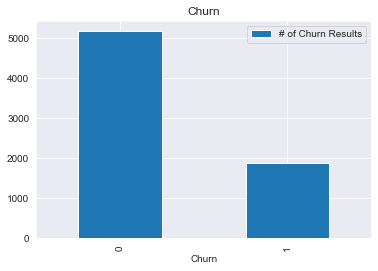

In [15]:
df.groupby('Churn').count().plot(kind='bar', y='gender', label='# of Churn Results')
plt.title('Churn')
print('Percentage of Churn Class in Data Set is {}'.format(round(len(df.loc[df['Churn'] == 1])/len(df) * 100, 2)))
print('Percentage of Did Not Churn Class in Data Set is {}'.format(round(len(df.loc[df['Churn'] == 0])/len(df) * 100, 2)))

The dataset is very imbalanced.  Only 26.58% of the customers churned vs 73.42% of customers who did not.  We will need to use synthetic samples or class weights to avoid class imbalance.

###### Create countplots for each categorical feature

In [16]:
# Function to create a count plot for each of the categorical features
fig, ax = plt.subplots(5, 3, figsize=(20, 20))
for variable, subplot in zip(categorical, ax.flatten()):
    sns.countplot(df[variable], ax=subplot, hue=df['Churn'])

##### Analyzing Catagorical Features

Based off these charts, I noticed that gender does not really have an effect on whether a customer will churn or not.  I will drop it.

In [17]:
# Drop gender column
df=df.drop('gender', axis=1)

Next I want to take a furthur look into the StreamingTV and StreamingMovies column.  They both sound very similar and there counts seem like the are the same.

In [18]:
df.StreamingTV.value_counts(normalize=True)

No     0.615614
Yes    0.384386
Name: StreamingTV, dtype: float64

In [19]:
df.StreamingMovies.value_counts(normalize=True)

No     0.611633
Yes    0.388367
Name: StreamingMovies, dtype: float64

As I thought they are almost identical.  I combine the two into a StreamingContent column.

In [20]:
df = df.drop(['StreamingMovies'], axis=1)

##### Create Histograms for Numerical Features

In [21]:
# Function to create a distance plot for each of the numerical features
fig, ax = plt.subplots(1, 3, figsize=(20, 6))
for variable, subplot in zip(numerical, ax.flatten()):
    sns.distplot(df[variable], ax=subplot)

Our numerical columns are not normally distributed.  They will be scaled later on in our modeling to ensure that the bigger numbers do no effect our results.

##### Create Heatmap to check for multicolinearity 

Text(0.5, 1, 'Feature Correlation')

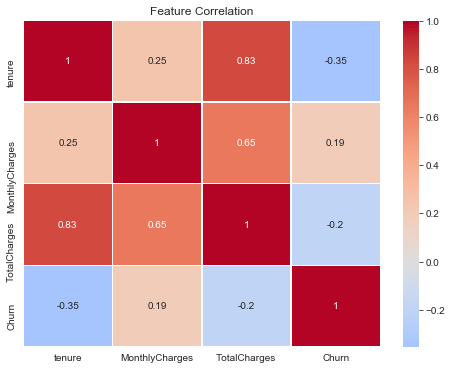

In [22]:
# Create heatmap
f, ax = plt.subplots(figsize=(8,6))
sns.heatmap(df.corr(), annot=True, center=0, linewidth=.5, ax=ax, cmap="coolwarm")
plt.title('Feature Correlation')

There is a high level of multicolinearity between TotalCharges and Tenure.  This makes sense as the longer you've been with the company, the higher the amount you will have been charged over the course of your contract.  This may affect our model later on, so we may have to drop one of these columns.

# Model Preprocessing

##### Split data into target and predictor dataframes to be used in modeling

In [23]:
y = df['Churn']
X = df.drop(columns='Churn', axis=1)

##### Create dummies for the categorical columns

In [24]:
X=pd.get_dummies(X, drop_first = True)

##### Standardize all of our target features using MinMaxScaler to ensure that the high numerical features do not impact our model more than the categorical features

In [25]:
# Use MinMaxScaler to scale data
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
X_scaled=pd.DataFrame(X_scaled, columns=X.columns)
X_scaled.head()

tenure  MonthlyCharges  TotalCharges  SeniorCitizen_Yes  Partner_Yes  \
0  0.000000        0.115423      0.001275                0.0          1.0   
1  0.464789        0.385075      0.215867                0.0          0.0   
2  0.014085        0.354229      0.010310                0.0          0.0   
3  0.619718        0.239303      0.210241                0.0          0.0   
4  0.014085        0.521891      0.015330                0.0          0.0   

   Dependents_Yes  MultipleLines_No phone service  MultipleLines_Yes  \
0             0.0                             1.0                0.0   
1             0.0                             0.0                0.0   
2             0.0                             0.0                0.0   
3             0.0                             1.0                0.0   
4             0.0                             0.0                0.0   

   InternetService_Fiber optic  InternetService_No  OnlineSecurity_Yes  \
0                          0.0                 0.0                 0.0   
1                          0.0                 0.0                 1.0   
2                          0.0                 0.0                 1.0   
3                          0.0                 0.0                 1.0   
4                          1.0                 0.0                 0.0   

   OnlineBackup_Yes  DeviceProtection_Yes  TechSupport_Yes  StreamingTV_Yes  \
0               1.0                   0.0              0.0              0.0   
1               0.0                   1.0              0.0              0.0   
2               1.0                   0.0              0.0              0.0   
3               0.0                   1.0              1.0              0.0   
4               0.0                   0.0              0.0              0.0   

   Contract_One year  Contract_Two year  PaperlessBilling_Yes  \
0                0.0                0.0                   1.0   
1                1.0                0.0                   0.0   
2                0.0                0.0                   1.0   
3                1.0                0.0                   0.0   
4                0.0                0.0                   1.0   

   PaymentMethod_Credit card (automatic)  PaymentMethod_Electronic check  \
0                                    0.0                             1.0   
1                                    0.0                             0.0   
2                                    0.0                             0.0   
3                                    0.0                             0.0   
4                                    0.0                             1.0   

   PaymentMethod_Mailed check  
0                         0.0  
1                         1.0  
2                         1.0  
3                         0.0  
4                         0.0

##### Pefrom train test split on our data

In [26]:
# Train test split of data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size = 0.25, random_state=42)

# Modeling

## Functions To Evaluate Model

##### Confusion Matrix

In [27]:
def confusion_matrix_df(y_test, y_pred_test):
    confusion_mat = confusion_matrix(y_test, y_pred_test, labels=[0, 1])
    _row = confusion_mat.sum(axis=0)
    _col = [np.nan] + list(confusion_mat.sum(axis=1)) + [sum(_row)]
    con_df = pd.DataFrame({})
    con_df["Predicted"] = ["Actual"] + ["No Churn", "Churn"] + ["All"]
    for label, idx in {"No Churn": 0, "Churn": 1}.items():
        temp = [np.nan] + list(confusion_mat[:, idx]) + [_row[idx]]
        con_df[label] = temp

    con_df["All"] = _col
    return con_df

##### Fuction to print the Confusion Matrix, Classification Report, Cohen's Kappa, F2 score, and the Mean Cross Validation

In [28]:
def model_evaluation(X_train, X_test, y_train, y_test, y_pred_train, y_pred_test):

    print('MODEL EVALUATION METRICS:\n',
          '-----------------------------------------------------')

    print('Confusion Matrix for train & test set: \n')
    print(confusion_matrix_df(y_train, y_pred_train), '\n')
    print(confusion_matrix_df(y_test, y_pred_test), '\n')

    print('-----------------------------------------------------')
    print('\nClassification Report for train & test set\n',
          '\nTrain set\n',
          classification_report(y_train, y_pred_train),
          '\n\nTest set\n',
          classification_report(y_test, y_pred_test))

    print('-----------------------------------------------------\n')
    print("Cohen's Kappa for train and test set:\n ",
          round(cohen_kappa_score(y_train, y_pred_train), 4),
          round(cohen_kappa_score(y_test, y_pred_test), 4))

    print("f2 score for train and test set: \n ",
          round(fbeta_score(y_train, y_pred_train, 2.0), 4),
          round(fbeta_score(y_test, y_pred_test, 2.0), 4))

##### Function to draw the ROC curve and calculate the Area Under the Curve

In [29]:
def roc_curve_and_auc(clf, X_train, X_test, y_train, y_test):

    # Calculate the probability scores of each point in the training set
    y_train_score = clf.fit(X_train, y_train).decision_function(X_train)

    # Calculate the fpr, tpr, and thresholds for the training set
    train_fpr, train_tpr, thresholds = roc_curve(y_train, y_train_score)

    # Calculate the probability scores of each point in the test set
    y_test_score = clf.decision_function(X_test)

    # Calculate the fpr, tpr, and thresholds for the test set
    test_fpr, test_tpr, test_thresholds = roc_curve(y_test, y_test_score)

    # ROC curve for training set
    plt.figure(figsize=(10, 8))
    lw = 2
    plt.plot(train_fpr, train_tpr, color='darkorange',
             lw=lw, label='Train ROC curve')
    plt.plot(test_fpr, test_tpr, color='blue',
             lw=lw, label='Test ROC curve')
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.yticks([i/20.0 for i in range(21)])
    plt.xticks([i/20.0 for i in range(21)])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(
        'Receiver operating characteristic (ROC) Curve for Training and Testing Sets')
    plt.legend(loc='lower right')
    plt.show()
    # Print the area under the roc curve
    print('Training AUC: {}'.format(round(auc(train_fpr, train_tpr), 5)))
    print('Testing AUC: {}'.format(round(auc(test_fpr, test_tpr), 5)))

##### Function to plot feature importance

In [63]:
def plot_feature_importance(model):
    # quickly plot the feature importance of features used in the model to be compared against each other
    n_features = X_train.shape[1]
    plt.figure(figsize=(8,8))
    plt.barh(range(n_features), model.feature_importances_, align='center') 
    plt.yticks(np.arange(n_features), X_train.columns.values) 
    plt.xlabel('Feature importance')
    plt.ylabel('Feature')

In [72]:
def plot_coefficients(clf):
    weights_clf = pd.Series(clf.coef_[0], index=X.columns.values)
    weights_clf.sort_values(inplace=True)
    plt.figure(figsize=(15, 6))
    plt.xticks(rotation=90)
    features = plt.bar(weights_clf.index, weights_clf.values)

## SMOTE

Perform Synthetic Minority Over-sampling Technique to our Train data so that we can oversample our Churn - Yes data to prevent class imbalance. 

In [30]:
print(y.value_counts())
smote = SMOTE()
X_train_SMOTE, y_train_SMOTE = smote.fit_sample(X_train, y_train) 
# Preview synthetic sample class distribution
print('-----------------------------------------')
print('Synthetic sample class distribution: \n')
print(pd.Series(y_train_SMOTE).value_counts())

0    5163
1    1869
Name: Churn, dtype: int64
-----------------------------------------
Synthetic sample class distribution: 

1    3863
0    3863
Name: Churn, dtype: int64


## Logistic Regression Model

### Baseline LogReg Model

In [67]:
# Instantiate the model
clf = LogisticRegression(fit_intercept=False, C=1e12, solver='liblinear')

# Fit the model
clf.fit(X_train, y_train)

LogisticRegression(C=1000000000000.0, class_weight=None, dual=False,
                   fit_intercept=False, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [68]:
# Generate predictions
y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)

In [69]:
# Run model evaluation
model_evaluation(X_train, X_test, y_train, y_test, y_pred_train, y_pred_test)

MODEL EVALUATION METRICS:
 -----------------------------------------------------
Confusion Matrix for train & test set: 

  Predicted  No Churn   Churn     All
0    Actual       NaN     NaN     NaN
1  No Churn    3437.0   426.0  3863.0
2     Churn     601.0   810.0  1411.0
3       All    4038.0  1236.0  5274.0 

  Predicted  No Churn  Churn     All
0    Actual       NaN    NaN     NaN
1  No Churn    1149.0  151.0  1300.0
2     Churn     212.0  246.0   458.0
3       All    1361.0  397.0  1758.0 

-----------------------------------------------------

Classification Report for train & test set
 
Train set
               precision    recall  f1-score   support

           0       0.85      0.89      0.87      3863
           1       0.66      0.57      0.61      1411

    accuracy                           0.81      5274
   macro avg       0.75      0.73      0.74      5274
weighted avg       0.80      0.81      0.80      5274
 

Test set
               precision    recall  f1-score   sup

In [70]:
# Draw ROC curve and calculate AUC
roc_curve_and_auc(clf, X_train, X_test, y_train, y_test)

Training AUC: 0.85139
Testing AUC: 0.83421


In [73]:
clf.coef_.round(2)

array([[-5.08, -0.67,  4.  ,  0.24,  0.09, -0.26,  0.47,  0.2 ,  0.89,
        -1.02, -0.44, -0.13,  0.04, -0.38,  0.31, -0.77, -1.36,  0.2 ,
        -0.21,  0.17, -0.22]])

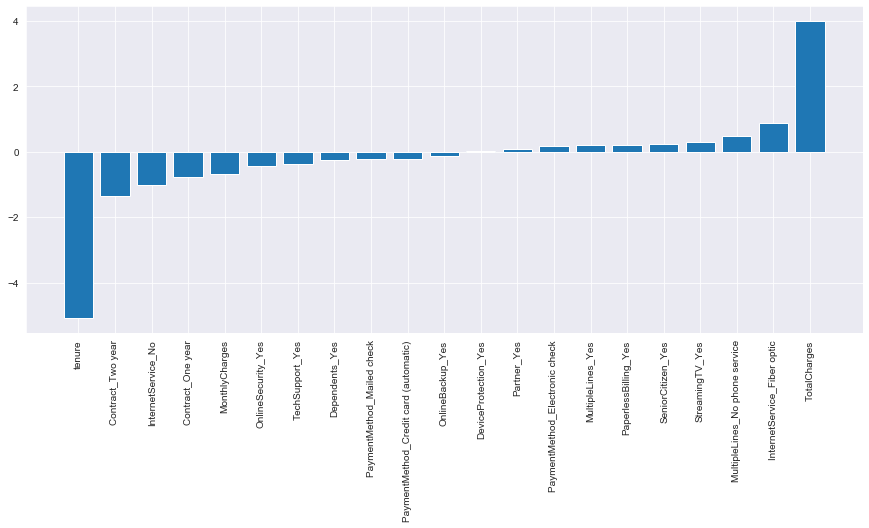

In [74]:
plot_coefficients(clf)

#### Baseline LogReg Interpretation

This baseline model did a poor job at predicting 1s (Customer Churns) with a testing recall of only .54. So 54% of the time our model was able to predict customer who churned.

The most important features for this model were: Tenure, TotalCharges, and Contract_Twoyear

### SMOTE LogReg Model

In [75]:
clf = LogisticRegression(fit_intercept=False, C=1e20, solver='liblinear')
clf.fit(X_train_SMOTE, y_train_SMOTE)
y_pred_train = clf.predict(X_train_SMOTE)
y_pred_test = clf.predict(X_test)

In [76]:
# Run model evaluation
model_evaluation(X_train_SMOTE, X_test, y_train_SMOTE, y_test, y_pred_train, y_pred_test)

MODEL EVALUATION METRICS:
 -----------------------------------------------------
Confusion Matrix for train & test set: 

  Predicted  No Churn   Churn     All
0    Actual       NaN     NaN     NaN
1  No Churn    2848.0  1015.0  3863.0
2     Churn     700.0  3163.0  3863.0
3       All    3548.0  4178.0  7726.0 

  Predicted  No Churn  Churn     All
0    Actual       NaN    NaN     NaN
1  No Churn     951.0  349.0  1300.0
2     Churn      91.0  367.0   458.0
3       All    1042.0  716.0  1758.0 

-----------------------------------------------------

Classification Report for train & test set
 
Train set
               precision    recall  f1-score   support

           0       0.80      0.74      0.77      3863
           1       0.76      0.82      0.79      3863

    accuracy                           0.78      7726
   macro avg       0.78      0.78      0.78      7726
weighted avg       0.78      0.78      0.78      7726
 

Test set
               precision    recall  f1-score   sup

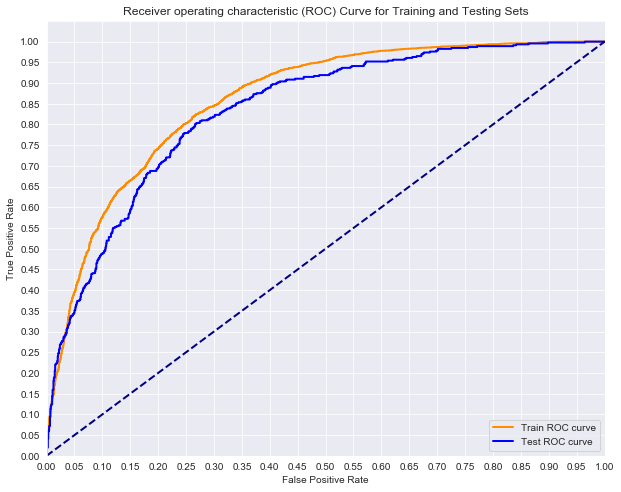

Training AUC: 0.8591
Testing AUC: 0.83424


In [77]:
# Draw ROC curve and calculate AUC
roc_curve_and_auc(clf, X_train_SMOTE, X_test, y_train_SMOTE, y_test)

In [78]:
clf.coef_.round(2)

array([[-5.11,  2.36,  3.85,  0.13,  0.1 , -0.36,  1.04,  0.04,  0.11,
        -0.15, -0.52, -0.25, -0.08, -0.55, -0.1 , -0.84, -1.42,  0.25,
        -0.04,  0.32, -0.14]])

In [79]:
plot_coefficients(clf)

##### SMOTE LogReg Interpretation

This smote model did a much better job at predicting 1s (Customer Churns) with a testing recall of only .80. So 80% of the time our model was able to predict customer who churned.

The most important features for this model were: Tenure, TotalCharges, and MonthlyCharges

### Balanced Weights LogReg Model

In [80]:
clf = LogisticRegression(fit_intercept=False, C=1e12,
                         solver='liblinear', class_weight='balanced')
clf.fit(X_train, y_train)
y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)

In [81]:
# Run model evaluation
model_evaluation(X_train, X_test, y_train, y_test, y_pred_train, y_pred_test)

MODEL EVALUATION METRICS:
 -----------------------------------------------------
Confusion Matrix for train & test set: 

  Predicted  No Churn   Churn     All
0    Actual       NaN     NaN     NaN
1  No Churn    2824.0  1039.0  3863.0
2     Churn     274.0  1137.0  1411.0
3       All    3098.0  2176.0  5274.0 

  Predicted  No Churn  Churn     All
0    Actual       NaN    NaN     NaN
1  No Churn     935.0  365.0  1300.0
2     Churn      91.0  367.0   458.0
3       All    1026.0  732.0  1758.0 

-----------------------------------------------------

Classification Report for train & test set
 
Train set
               precision    recall  f1-score   support

           0       0.91      0.73      0.81      3863
           1       0.52      0.81      0.63      1411

    accuracy                           0.75      5274
   macro avg       0.72      0.77      0.72      5274
weighted avg       0.81      0.75      0.76      5274
 

Test set
               precision    recall  f1-score   sup

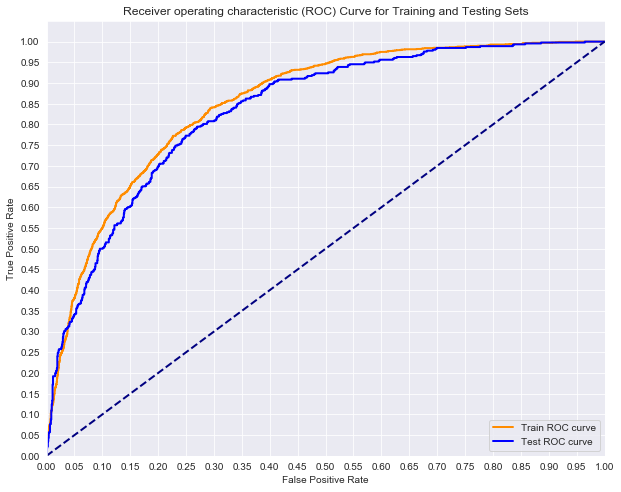

Training AUC: 0.8516
Testing AUC: 0.83412


In [82]:
# Draw ROC curve and calculate AUC
roc_curve_and_auc(clf, X_train, X_test, y_train, y_test)

In [83]:
clf.coef_.round(2)

array([[-4.24,  1.9 ,  2.96,  0.25,  0.1 , -0.24,  0.95,  0.05,  0.3 ,
        -0.27, -0.51, -0.22, -0.11, -0.45,  0.03, -0.81, -1.45,  0.21,
        -0.07,  0.3 , -0.09]])

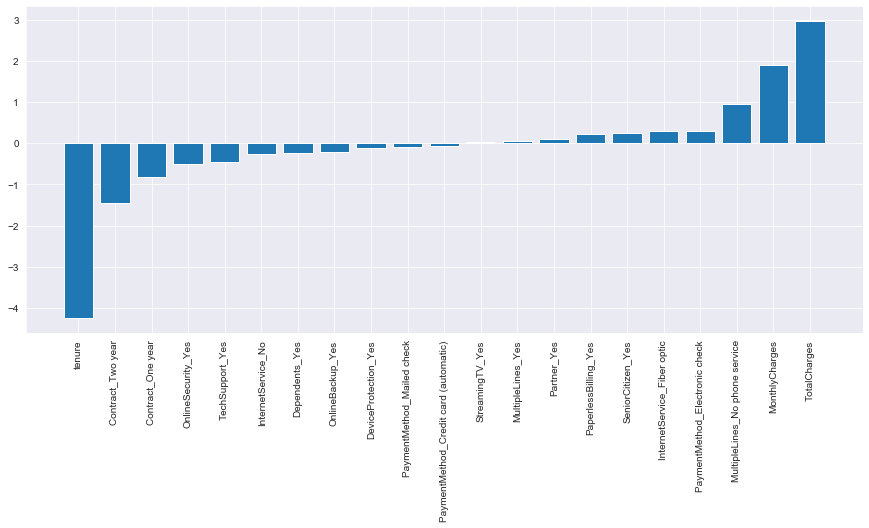

In [84]:
plot_coefficients(clf)

##### Balanced Weights LogReg Interpretation

This model performed about the same as our SMOTE model did.  It had a testing recall of .80. So 80% of the time our model was able to predict customer who churned.

The most important features for this model were: Tenure, TotalCharges, and MonthlyCharges

## Support Vector Machines

### Baseline Model

In [85]:
clf = SVC(kernel='linear', class_weight='balanced')
clf.fit(X_train, y_train)
y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)

In [86]:
# Run model evaluation
model_evaluation(X_train, X_test, y_train, y_test, y_pred_train, y_pred_test)

MODEL EVALUATION METRICS:
 -----------------------------------------------------
Confusion Matrix for train & test set: 

  Predicted  No Churn   Churn     All
0    Actual       NaN     NaN     NaN
1  No Churn    2536.0  1327.0  3863.0
2     Churn     234.0  1177.0  1411.0
3       All    2770.0  2504.0  5274.0 

  Predicted  No Churn  Churn     All
0    Actual       NaN    NaN     NaN
1  No Churn     832.0  468.0  1300.0
2     Churn      79.0  379.0   458.0
3       All     911.0  847.0  1758.0 

-----------------------------------------------------

Classification Report for train & test set
 
Train set
               precision    recall  f1-score   support

           0       0.92      0.66      0.76      3863
           1       0.47      0.83      0.60      1411

    accuracy                           0.70      5274
   macro avg       0.69      0.75      0.68      5274
weighted avg       0.80      0.70      0.72      5274
 

Test set
               precision    recall  f1-score   sup

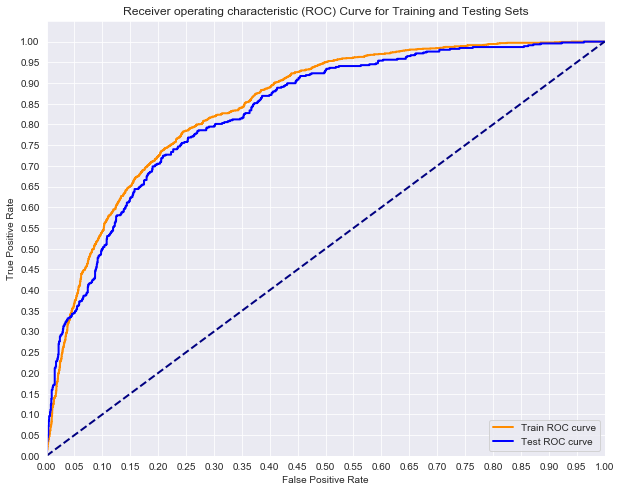

Training AUC: 0.84651
Testing AUC: 0.83133


In [87]:
# Draw ROC curve and calculate AUC
roc_curve_and_auc(clf, X_train, X_test, y_train, y_test)

##### Baseline SVM Interpretation

This baseline SVM model did a great job at predicting 1s (Customer Churns) with a testing recall of .83. So 83% of the time our model was able to predict customer who churned.

There were significantly more False negatives in this model though which is bad because for this business case False Negatives are a bigger problem than Precision of the model


### GridSearch Model

Ran GridSearch to determine best values for C and gamma for SVM

C is a regularization parameter that controls the trade off between the achieving a low training error and a low testing error that is the ability to generalize your classifier to unseen data.

Gamma parameter defines how far the influence of a single training example reaches, with low values meaning 'far' and high values meaning 'close'. The gamma parameters can be seen as the inverse of the radius of influence of samples selected by the model as support vectors.

In [44]:
svm_clf = SVC(kernel='linear', class_weight='balanced')
param_grid = {
     'C':[0.1,1,10,100,1000],
    'gamma':[1,0.1,0.01,0.001,0.0001]

}
gs_svm = GridSearchCV(svm_clf, param_grid, cv=3, n_jobs=-1)
gs_svm.fit(X_train, y_train)

gs_svm.best_params_

{'C': 1000, 'gamma': 1}

In [45]:
svm_clf = SVC(C=1000, gamma=1, kernel='linear',class_weight='balanced')
svm_clf.fit(X_train, y_train)

SVC(C=1000, break_ties=False, cache_size=200, class_weight='balanced',
    coef0=0.0, decision_function_shape='ovr', degree=3, gamma=1,
    kernel='linear', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

In [46]:
y_pred_train = svm_clf.predict(X_train)
y_pred_test = svm_clf.predict(X_test)

In [47]:
# Run model evaluation
model_evaluation(X_train, X_test, y_train, y_test, y_pred_train, y_pred_test)

MODEL EVALUATION METRICS:
 -----------------------------------------------------
Confusion Matrix for train & test set: 

  Predicted  No Churn   Churn     All
0    Actual       NaN     NaN     NaN
1  No Churn    2536.0  1327.0  3863.0
2     Churn     234.0  1177.0  1411.0
3       All    2770.0  2504.0  5274.0 

  Predicted  No Churn  Churn     All
0    Actual       NaN    NaN     NaN
1  No Churn     832.0  468.0  1300.0
2     Churn      79.0  379.0   458.0
3       All     911.0  847.0  1758.0 

-----------------------------------------------------

Classification Report for train & test set
 
Train set
               precision    recall  f1-score   support

           0       0.92      0.66      0.76      3863
           1       0.47      0.83      0.60      1411

    accuracy                           0.70      5274
   macro avg       0.69      0.75      0.68      5274
weighted avg       0.80      0.70      0.72      5274
 

Test set
               precision    recall  f1-score   sup

In [49]:
# Draw ROC curve and calculate AUC
roc_curve_and_auc(svm_clf, X_train, X_test, y_train, y_test)

Training AUC: 0.84789
Testing AUC: 0.83184


##### Gridsearch SVM  Interpretation

This Gridsearch SVM model performed almost exactly the same as the Baseline SVM with a testing recall of .83. So 83% of the time our model was able to predict customer who churned.

It again had problems predicting True Positives and predicts more False Negatives.

## Random Forest Model

### Baseline Model

In [50]:
clf = RandomForestClassifier(
    max_depth=5, n_jobs=-1, class_weight='balanced', random_state=42)
clf.fit(X_train, y_train)
y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)

In [51]:
# Run model evaluation
model_evaluation(X_train, X_test, y_train, y_test, y_pred_train, y_pred_test)

MODEL EVALUATION METRICS:
 -----------------------------------------------------
Confusion Matrix for train & test set: 

  Predicted  No Churn   Churn     All
0    Actual       NaN     NaN     NaN
1  No Churn    2896.0   967.0  3863.0
2     Churn     249.0  1162.0  1411.0
3       All    3145.0  2129.0  5274.0 

  Predicted  No Churn  Churn     All
0    Actual       NaN    NaN     NaN
1  No Churn     928.0  372.0  1300.0
2     Churn      96.0  362.0   458.0
3       All    1024.0  734.0  1758.0 

-----------------------------------------------------

Classification Report for train & test set
 
Train set
               precision    recall  f1-score   support

           0       0.92      0.75      0.83      3863
           1       0.55      0.82      0.66      1411

    accuracy                           0.77      5274
   macro avg       0.73      0.79      0.74      5274
weighted avg       0.82      0.77      0.78      5274
 

Test set
               precision    recall  f1-score   sup

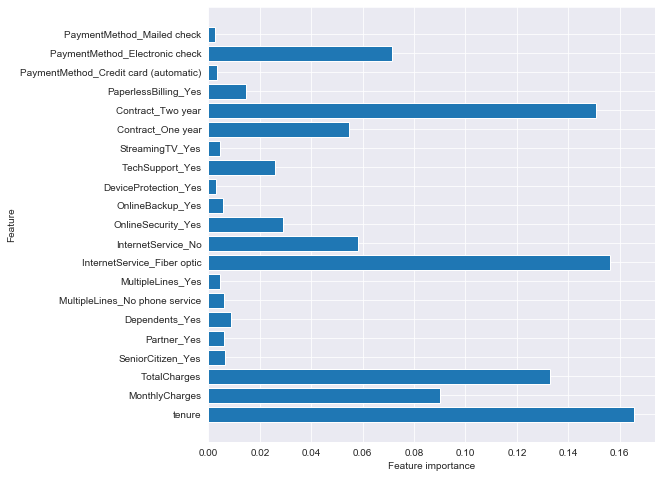

In [65]:
plot_feature_importance(clf)

##### Baseline RFC Interpretation

This baseline RFC model did a good job at predicting 1s (Customer Churns) with a testing recall of .79. So 79% of the time our model was able to predict customer who churned.

This model shows alot of overfitting though which is expected because RFC models are greedy learners and will exhaust all possibilities for fit unless you tune the hyperparameters.

The top features for this model were: Tenure, InternetService_Fiber optic, and Contract_Two year

### GridSearch Model

In [59]:
forest = RandomForestClassifier()
param_grid = {
    'max_features' : ['auto','log2'],
    'criterion' : ['gini','entropy'],
    'n_estimators' : [100, 150, 200, 250, 300],
    'max_depth' : [5,6,7,8,9,10],
    'min_samples_split' : [2, 5, 10, 15],
    'min_samples_leaf' : [1, 2, 5, 10] 
}
forest = GridSearchCV(forest, param_grid, cv=3, n_jobs=-1)
forest.fit(X_train, y_train)

forest.best_params_

{'criterion': 'entropy',
 'max_depth': 8,
 'max_features': 'log2',
 'min_samples_leaf': 10,
 'min_samples_split': 10,
 'n_estimators': 100}

In [61]:
forest = RandomForestClassifier(n_estimators=100, criterion='entropy', min_samples_leaf = 10, min_samples_split = 10, max_depth = 5, class_weight='balanced', max_features='log2')
forest.fit(X_train,y_train)
y_pred_train = forest.predict(X_train)
y_pred_test = forest.predict(X_test)

In [62]:
# Run model evaluation
model_evaluation(X_train, X_test, y_train, y_test, y_pred_train, y_pred_test)

MODEL EVALUATION METRICS:
 -----------------------------------------------------
Confusion Matrix for train & test set: 

  Predicted  No Churn   Churn     All
0    Actual       NaN     NaN     NaN
1  No Churn    2870.0   993.0  3863.0
2     Churn     251.0  1160.0  1411.0
3       All    3121.0  2153.0  5274.0 

  Predicted  No Churn  Churn     All
0    Actual       NaN    NaN     NaN
1  No Churn     930.0  370.0  1300.0
2     Churn      92.0  366.0   458.0
3       All    1022.0  736.0  1758.0 

-----------------------------------------------------

Classification Report for train & test set
 
Train set
               precision    recall  f1-score   support

           0       0.92      0.74      0.82      3863
           1       0.54      0.82      0.65      1411

    accuracy                           0.76      5274
   macro avg       0.73      0.78      0.74      5274
weighted avg       0.82      0.76      0.78      5274
 

Test set
               precision    recall  f1-score   sup

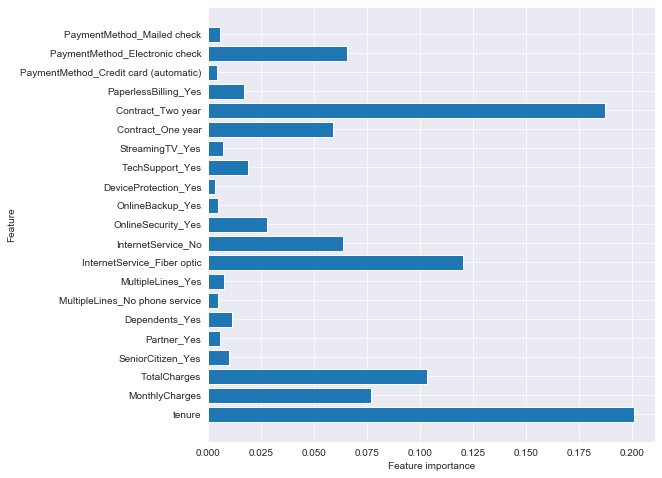

In [64]:
plot_feature_importance(forest)

##### Gridsearch RFC Interpretation

This Gridsearch RFC model did a better job at predicting 1s (Customer Churns) with a testing recall of .80. So 80% of the time our model was able to predict customer who churned.

Gridsearch was also able to get rid of our overfitting issues.

The top features for this model were: Tenure, Contract_Two year, and InternetService_Fiber optic

# Business Recommendations

1. Features that most effect Customer Churn
    * Increase Churn: Fiber Optic Internet Sevice, Monthly Contract
    * Decrease Churn: Tenure, One/Two Year Contract, No Internet Service

2. Recommendations
    * The fiber optic internet service is causing customers to leave but the Customers with no internet seem to be staying at a higher rate.  This leads me to believe that the Internet Service is poor quality.  Focus on improving the quality and coverage of the internet service.   
    
    * Focus on signing up customers for a One/Two Year Contract as opposed to monthly.  Offer incentives that the customer will only recieve via a yearly contract.
    
    * Offer loyalty rewards to long term customers to show your appreciation for their tenure
    
3. Model
    * Model was able to predict customer churn with a 83% accuracy
    * Input customer data to predict whether they will churn
    * Focus retention efforts on customers that are predicted to churn through promotional offers 